<a href="https://colab.research.google.com/github/dvnananth/rasmitha/blob/main/FMNIST_CNN_WnB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 0: Install WandB if not installed
!pip install -q wandb

In [2]:
# Step 1: Imports
import os
import gzip
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import wandb
import matplotlib.pyplot as plt

In [3]:
# Step 2: Download Fashion-MNIST data (gzipped)
!wget -N http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget -N http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget -N http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget -N http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
DATA_PATH = "/content"

--2026-01-30 03:56:00--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.46.26, 16.12.24.44, 3.5.138.178, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.46.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M   108MB/s    in 0.2s    

2026-01-30 03:56:01 (108 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2026-01-30 03:56:01--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.46.26, 16.12.24.44, 3.5.138.178, ..

In [14]:
# Step 3: Loader function for MNIST IDX files
def load_mnist(path, kind='train'):
    FILE_MAP = {
        'train': ('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz'),
        't10k': ('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')
    }

    images_file, labels_file = FILE_MAP[kind]
    images_path = os.path.join(path, images_file)
    labels_path = os.path.join(path, labels_file)

    # Load labels
    with gzip.open(labels_path, 'rb') as f:
        labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

    # Load images
    with gzip.open(images_path, 'rb') as f:
        images = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels


In [5]:
# Step 4: Load datasets
images_train, labels_train = load_mnist(DATA_PATH, 'train')
images_test, labels_test = load_mnist(DATA_PATH, 't10k')

print("Train images:", images_train.shape, "Train labels:", labels_train.shape)
print("Test images:", images_test.shape, "Test labels:", labels_test.shape)


Train images: (60000, 784) Train labels: (60000,)
Test images: (10000, 784) Test labels: (10000,)


In [16]:
# Step 5: Define PyTorch Dataset
class FMNISTDataset(Dataset):
    def __init__(self, images, labels, device='cpu'):
        self.images = images
        self.labels = labels
        self.device = device

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx], dtype=torch.float32).view(1, 28, 28)
        img =img / 255.0
        lbl = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, lbl

traindata = FMNISTDataset(images_train, labels_train)
testdata = FMNISTDataset(images_test, labels_test)

trainloader = DataLoader(traindata, batch_size=64, shuffle=True)
testloader = DataLoader(testdata, batch_size=64)

In [17]:
# Step 6: Define CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = SimpleCNN()

TypeError: to() received an invalid combination of arguments - got (module), but expected one of:
 * (torch.device device = None, torch.dtype dtype = None, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (torch.dtype dtype, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (Tensor tensor, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)


In [8]:
# Step 7: Initialize W&B
wandb.init(
    project="fmnist-tutorial",
    config={
        "learning_rate": 0.001,
        "architecture": "CNN",
        "dataset": "Fashion-MNIST",
        "epochs": 5
    }
)
wandb.watch(model, log_freq=100)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"
wandb: Using W&B in offline mode.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [9]:
# Step 8: Loss and optimizer
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config.learning_rate)

In [10]:
# Step 9: Training loop with W&B logging
epochs = wandb.config.epochs
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 100 == 0:
            wandb.log({"batch_loss": loss.item(), "epoch": epoch})

    avg_loss = running_loss / len(trainloader)
    wandb.log({"epoch_loss": avg_loss, "epoch": epoch})
    print(f"Epoch {epoch} average loss: {avg_loss:.4f}")

Epoch 0 average loss: 0.5011
Epoch 1 average loss: 0.3233
Epoch 2 average loss: 0.2722
Epoch 3 average loss: 0.2407
Epoch 4 average loss: 0.2154


In [11]:
# Step 10: Evaluate on test set
model.eval()
correct = 0
total = 0
test_loss = 0
with torch.no_grad():
    for data, target in testloader:
        output = model(data)
        test_loss += loss_fn(output, target).item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

test_accuracy = 100 * correct / total
test_loss /= len(testloader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
wandb.log({"test_loss": test_loss, "test_accuracy": test_accuracy})

Test Loss: 0.2675, Test Accuracy: 90.18%


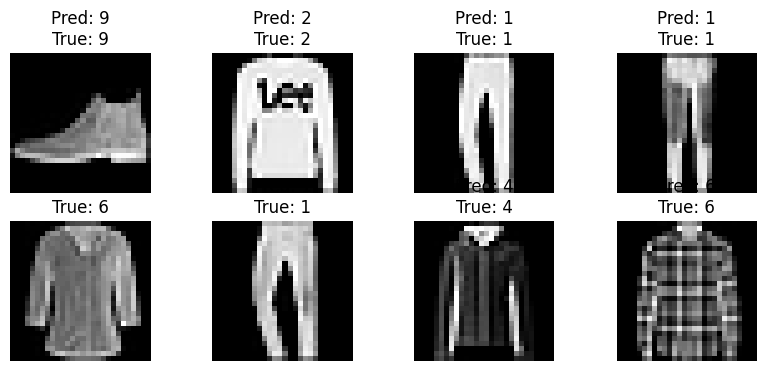

batch_loss,█▃▃▂▂▂▃▂▂▂▂▁▂▂▂▁▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂
epoch,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆████████
epoch_loss,█▄▂▂▁
test_accuracy,▁
test_loss,▁
batch_loss,0.24802
epoch,4
epoch_loss,0.21538
test_accuracy,90.18
test_loss,0.2675


In [12]:
# Step 11: Visualize some test images with predictions
data_iter = iter(testloader)
images, labels = next(data_iter)
outputs = model(images)
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(10,4))
for idx in range(8):
    ax = fig.add_subplot(2,4,idx+1)
    ax.imshow(images[idx].cpu().squeeze(), cmap='gray')
    ax.set_title(f"Pred: {preds[idx].item()}\nTrue: {labels[idx].item()}")
    ax.axis('off')
plt.show()

# Finish W&B run
wandb.finish()